##### Steps for reading in dataset (following download), initial QC, dim reduction/clustering and saving out the myeloid cluster for **GSE131907**

files previously downloaded:
* GSE131907_Lung_Cancer_cell_annotation.txt.gz
* GSE131907_Lung_Cancer_Feature_Summary.xlsx
* GSE131907_Lung_Cancer_normalized_log2TPM_matrix.rds.gz
* GSE131907_Lung_Cancer_normalized_log2TPM_matrix.txt.gz
* **GSE131907_Lung_Cancer_raw_UMI_matrix.rds**
* GSE131907_Lung_Cancer_raw_UMI_matrix.txt.gz

Using this file: 
* GSE131907_Lung_Cancer_raw_UMI_matrix.rds

##### Samples are from lung adenocarcinoma (LUAD)
##### All patients together in one object, can distinguish samples by suffix on barcode (PMID 32385277 for details). 
* LUNG_N01, LUNG_N06, LUNG_N08, LUNG_N09, LUNG_N18, LUNG_N19, LUNG_N20, LUNG_N28, LUNG_N30, LUNG_N31, LUNG_N34 --> normal lung (**USE**)
* LUNG_T06, LUNG_T08, LUNG_T09, LUNG_T18, LUNG_T19, LUNG_T20, LUNG_T25, LUNG_T28, LUNG_T30, LUNG_T31, LUNG_T34 --> early stage tumour lung (**USE**)
* EBUS_06, EBUS_28, EBUS_49, BRONCHO_58 --> advanced stage tumour lung (**USE**)
* EBUS_10, BRONCHO_11, EBUS_12, EBUS_13, EBUS_15, EBUS_19, EBUS_51 --> LN mets (**USE**)
* LN_01, LN_02, LN_03, LN_04, LN_05, LN_06, LN_07, LN_08, LN_11, LN_12 --> normal LN (DONT USE)
* EFFUSION_06, EFFUSION_11, EFFUSION_12, EFFUSION_13, EFFUSION_64 --> pleural effusion (DONT USE)
* NS_02, NS_03, NS_04, NS_06, NS_07, NS_12, NS_13, NS_16, NS_17, NS_19 --> brain mets (**USE**)




In [1]:
#set wd
getwd()
setwd('/scratch/user/s4436039/scdata/GSE131907')
getwd()

[1] "/scratch/user/s4436039/Nikita-project"

[1] "/scratch/user/s4436039/scdata/GSE131907"

In [2]:
#Load packages
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [3]:
#load all datasets
LUAD.data <- readRDS("GSE131907_Lung_Cancer_raw_UMI_matrix.rds")

In [4]:
head(colnames(LUAD.data))
#can see below that patients can be distinguished by suffix on barcode, see top for summary of samples

[1] "AAACCTGAGAAACCGC_LN_05"    "AAACCTGAGAAACGCC_NS_13"   
[3] "AAACCTGAGAAGGTGA_LUNG_N18" "AAACCTGAGACAAAGG_LUNG_N18"
[5] "AAACCTGAGACATAAC_LN_04"    "AAACCTGAGACCTTTG_LUNG_N30"

In [69]:
#create seurat object for sample
LUAD <- CreateSeuratObject(counts = LUAD.data, project = "GSE131907", min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


In [70]:
head(LUAD@meta.data)

orig.ident nCount_RNA nFeature_RNA
AAACCTGAGAAACCGC_LN_05    GSE131907  19928      1690        
AAACCTGAGAAACGCC_NS_13    GSE131907   1382       611        
AAACCTGAGAAGGTGA_LUNG_N18 GSE131907   3214      1113        
AAACCTGAGACAAAGG_LUNG_N18 GSE131907   2990      1100        
AAACCTGAGACATAAC_LN_04    GSE131907   3880       948        
AAACCTGAGACCTTTG_LUNG_N30 GSE131907   2565       847

In [71]:
#extract the cell barcodes
bc_meta <- row.names(LUAD@meta.data)

In [72]:
# split each cell barcode by the separator, which is _. this will return a list, each with 3 entries
bc_meta <- strsplit(bc_meta, "_")

In [73]:
bc_meta[[1]]

[1] "AAACCTGAGAAACCGC" "LN"               "05"

In [74]:
# collapse the list to make a 3 column dataframe
bc_meta <- as.data.frame(do.call(rbind, bc_meta))

In [75]:
head(bc_meta)

V1               V2   V3 
1 AAACCTGAGAAACCGC LN   05 
2 AAACCTGAGAAACGCC NS   13 
3 AAACCTGAGAAGGTGA LUNG N18
4 AAACCTGAGACAAAGG LUNG N18
5 AAACCTGAGACATAAC LN   04 
6 AAACCTGAGACCTTTG LUNG N30

In [76]:
# merge the columns we want
LUAD@meta.data$sample_meta <- paste0(bc_meta[,2], "_", bc_meta[,3])

In [77]:
head(LUAD@meta.data)

orig.ident nCount_RNA nFeature_RNA sample_meta
AAACCTGAGAAACCGC_LN_05    GSE131907  19928      1690         LN_05      
AAACCTGAGAAACGCC_NS_13    GSE131907   1382       611         NS_13      
AAACCTGAGAAGGTGA_LUNG_N18 GSE131907   3214      1113         LUNG_N18   
AAACCTGAGACAAAGG_LUNG_N18 GSE131907   2990      1100         LUNG_N18   
AAACCTGAGACATAAC_LN_04    GSE131907   3880       948         LN_04      
AAACCTGAGACCTTTG_LUNG_N30 GSE131907   2565       847         LUNG_N30

In [78]:
#see what samples I have 
table(LUAD$sample_meta)


 BRONCHO_11  BRONCHO_58     EBUS_06     EBUS_10     EBUS_12     EBUS_13 
       3178        2813        2303        5144        3115        3550 
    EBUS_15     EBUS_19     EBUS_28     EBUS_49     EBUS_51 EFFUSION_06 
       1105        2112        5182        1775        3275        4884 
EFFUSION_11 EFFUSION_12 EFFUSION_13 EFFUSION_64       LN_01       LN_02 
       2943        4224        4441        3812        3626        3178 
      LN_03       LN_04       LN_05       LN_06       LN_07       LN_08 
       3013        3092        3087        2936        5713        4395 
      LN_11       LN_12    LUNG_N01    LUNG_N06    LUNG_N08    LUNG_N09 
       3788        4618        3194        2839        3380        2528 
   LUNG_N18    LUNG_N19    LUNG_N20    LUNG_N28    LUNG_N30    LUNG_N31 
       4628        3870        5798        3411        3884        4241 
   LUNG_N34    LUNG_T06    LUNG_T08    LUNG_T09    LUNG_T18    LUNG_T19 
       5222        3426        3765        3840   

Giving all samples a unique sample id --> letter corresponds to tissue and number is the original patient id from supp table of paper (same number implied matched sample)

Note: combining early and late stage tumour together 

Tumour:
* LUNG_T06 --> T0006
* LUNG_T08 --> T0008
* LUNG_T09 --> T0009
* LUNG_T18 --> T0018
* LUNG_T19 --> T0019
* LUNG_T20 --> T0020
* LUNG_T25 --> T0025
* LUNG_T28 --> T0028
* LUNG_T30 --> T0030
* LUNG_T31 --> T0031
* LUNG_T34 --> T0034
* EBUS_06 -->  T1006
* EBUS_28 --> T1028
* EBUS_49 --> T1049
* BRONCHO_58 --> T1058

Normal lung: 
* LUNG_N01 --> N0001
* LUNG_N06 --> N0006
* LUNG_N08 --> N0008
* LUNG_N09 --> N0009
* LUNG_N18 --> N0018
* LUNG_N19 --> N0019
* LUNG_N20 --> N0020
* LUNG_N28 --> N0028
* LUNG_N30 --> N0030
* LUNG_N31 --> N0031
* LUNG_N34 --> N0034

LN mets
* EBUS_10 --> L1010
* BRONCHO_11 --> L1011
* EBUS_12 --> L1012
* EBUS_13 --> L1013
* EBUS_15 --> L1015
* EBUS_19 --> L1019
* EBUS_51 --> L1051

Brain mets
* NS_02 --> B3002
* NS_03 --> B3003
* NS_04 --> B3004
* NS_06 --> B3006
* NS_07 --> B3007
* NS_12 --> B3012
* NS_13 --> B3013
* NS_16 --> B3016
* NS_17 --> B3017
* NS_19 --> B3019

Other
* LN_01, LN_02, LN_03, LN_04, LN_05, LN_06, LN_07, LN_08, LN_11, LN_12 --> normal LN (**DONT USE**)
* EFFUSION_06, EFFUSION_11, EFFUSION_12, EFFUSION_13, EFFUSION_64 --> pleural effusion (**DONT USE**)

In [79]:
#split in to seperate seurat objects per sample
N0001 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N01"))
N0006 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N06"))
N0008 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N08"))
N0009 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N09"))
N0018 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N18"))
N0019 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N19"))
N0020 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N20"))
N0028 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N28"))
N0030 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N30"))
N0031 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N31"))
N0034 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N34"))

T0006 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T06"))
T0008 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T08"))
T0009 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T09"))
T0018 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T18"))
T0019 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T19"))
T0020 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T20"))
T0025 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T25"))
T0028 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T28"))
T0030 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T30"))
T0031 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T31"))
T0034 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T34"))
T1006 <- subset(LUAD, subset = sample_meta %in% c("EBUS_06")) 
T1028 <- subset(LUAD, subset = sample_meta %in% c("EBUS_28"))
T1049 <- subset(LUAD, subset = sample_meta %in% c("EBUS_49"))
T1058 <- subset(LUAD, subset = sample_meta %in% c("BRONCHO_58"))

L1010 <- subset(LUAD, subset = sample_meta %in% c("EBUS_10"))
L1011 <- subset(LUAD, subset = sample_meta %in% c("BRONCHO_11"))
L1012 <- subset(LUAD, subset = sample_meta %in% c("EBUS_12"))
L1013 <- subset(LUAD, subset = sample_meta %in% c("EBUS_13"))
L1015 <- subset(LUAD, subset = sample_meta %in% c("EBUS_15"))
L1019 <- subset(LUAD, subset = sample_meta %in% c("EBUS_19"))
L1051 <- subset(LUAD, subset = sample_meta %in% c("EBUS_51"))

B3002 <- subset(LUAD, subset = sample_meta %in% c("NS_02"))
B3003 <- subset(LUAD, subset = sample_meta %in% c("NS_03"))
B3004 <- subset(LUAD, subset = sample_meta %in% c("NS_04"))
B3006 <- subset(LUAD, subset = sample_meta %in% c("NS_06"))
B3007 <- subset(LUAD, subset = sample_meta %in% c("NS_07"))
B3012 <- subset(LUAD, subset = sample_meta %in% c("NS_12"))
B3013 <- subset(LUAD, subset = sample_meta %in% c("NS_13"))
B3016 <- subset(LUAD, subset = sample_meta %in% c("NS_16"))
B3017 <- subset(LUAD, subset = sample_meta %in% c("NS_17"))
B3019 <- subset(LUAD, subset = sample_meta %in% c("NS_19"))

In [80]:
table(N0001$sample_meta)
table(N0006$sample_meta)
table(N0008$sample_meta)
table(N0009$sample_meta)
table(N0018$sample_meta)
table(N0019$sample_meta)
table(N0020$sample_meta)
table(N0028$sample_meta)
table(N0030$sample_meta)
table(N0031$sample_meta)
table(N0034$sample_meta)
table(T0006$sample_meta)
table(T0008$sample_meta)
table(T0009$sample_meta)
table(T0018$sample_meta)
table(T0019$sample_meta)
table(T0020$sample_meta)
table(T0025$sample_meta)
table(T0028$sample_meta)
table(T0030$sample_meta)
table(T0031$sample_meta)
table(T0034$sample_meta)
table(T1006$sample_meta)
table(T1028$sample_meta)
table(T1049$sample_meta)
table(T1058$sample_meta)
table(L1010$sample_meta)
table(L1011$sample_meta)
table(L1012$sample_meta)
table(L1013$sample_meta)
table(L1015$sample_meta)
table(L1019$sample_meta)
table(L1051$sample_meta)
table(B3002$sample_meta)
table(B3003$sample_meta)
table(B3004$sample_meta)
table(B3006$sample_meta)
table(B3007$sample_meta)
table(B3012$sample_meta)
table(B3013$sample_meta)
table(B3016$sample_meta)
table(B3017$sample_meta)
table(B3019$sample_meta)


LUNG_N01 
    3194 


LUNG_N06 
    2839 


LUNG_N08 
    3380 


LUNG_N09 
    2528 


LUNG_N18 
    4628 


LUNG_N19 
    3870 


LUNG_N20 
    5798 


LUNG_N28 
    3411 


LUNG_N30 
    3884 


LUNG_N31 
    4241 


LUNG_N34 
    5222 


LUNG_T06 
    3426 


LUNG_T08 
    3765 


LUNG_T09 
    3840 


LUNG_T18 
    3705 


LUNG_T19 
    4361 


LUNG_T20 
    4021 


LUNG_T25 
    4374 


LUNG_T28 
    4705 


LUNG_T30 
    4094 


LUNG_T31 
    5578 


LUNG_T34 
    3280 


EBUS_06 
   2303 


EBUS_28 
   5182 


EBUS_49 
   1775 


BRONCHO_58 
      2813 


EBUS_10 
   5144 


BRONCHO_11 
      3178 


EBUS_12 
   3115 


EBUS_13 
   3550 


EBUS_15 
   1105 


EBUS_19 
   2112 


EBUS_51 
   3275 


NS_02 
 2313 


NS_03 
 2990 


NS_04 
 1904 


NS_06 
 1070 


NS_07 
 5730 


NS_12 
 3182 


NS_13 
 4845 


NS_16 
 1317 


NS_17 
 2409 


NS_19 
 3300 

In [81]:
head(colnames(N0006))
head(colnames(T1049))
head(colnames(L1015))
head(colnames(B3003))

[1] "AAACCTGAGATGTGGC_LUNG_N06" "AAACCTGAGTGAAGTT_LUNG_N06"
[3] "AAACCTGCAAGAAGAG_LUNG_N06" "AAACCTGCAATGCCAT_LUNG_N06"
[5] "AAACCTGCACGGTTTA_LUNG_N06" "AAACCTGCAGACAAAT_LUNG_N06"

[1] "AAACCTGAGGCCCTTG_EBUS_49" "AAACCTGAGGTAAACT_EBUS_49"
[3] "AAACCTGCAATGAAAC_EBUS_49" "AAACCTGCATCTACGA_EBUS_49"
[5] "AAACCTGCATGCATGT_EBUS_49" "AAACGGGGTAAAGTCA_EBUS_49"

[1] "AAACCTGGTACTTAGC_EBUS_15" "AAACGGGAGCTCTCGG_EBUS_15"
[3] "AAACGGGCATGAAGTA_EBUS_15" "AAACGGGTCTAACTTC_EBUS_15"
[5] "AAAGATGCATGACATC_EBUS_15" "AAAGATGGTCTTCTCG_EBUS_15"

[1] "AAACCTGTCAAACAAG_NS_03" "AAACCTGTCACCATAG_NS_03" "AAACCTGTCCCACTTG_NS_03"
[4] "AAACGGGAGAGTACCG_NS_03" "AAACGGGAGATGTGTA_NS_03" "AAACGGGAGTAGGTGC_NS_03"

In [82]:
#Add dataset info to colnames
colnames(N0001) <- paste0("GSE131907_Normal_N0001_", colnames(N0001))
colnames(N0006) <- paste0("GSE131907_Normal_N0006_", colnames(N0006))
colnames(N0008) <- paste0("GSE131907_Normal_N0008_", colnames(N0008))
colnames(N0009) <- paste0("GSE131907_Normal_N0009_", colnames(N0009))
colnames(N0018) <- paste0("GSE131907_Normal_N0018_", colnames(N0018))
colnames(N0019) <- paste0("GSE131907_Normal_N0019_", colnames(N0019))
colnames(N0020) <- paste0("GSE131907_Normal_N0020_", colnames(N0020))
colnames(N0028) <- paste0("GSE131907_Normal_N0028_", colnames(N0028))
colnames(N0030) <- paste0("GSE131907_Normal_N0030_", colnames(N0030))
colnames(N0031) <- paste0("GSE131907_Normal_N0031_", colnames(N0031))
colnames(N0034) <- paste0("GSE131907_Normal_N0034_", colnames(N0034))

colnames(T0006) <- paste0("GSE131907_LUAD_Tu_T0006_", colnames(T0006))
colnames(T0008) <- paste0("GSE131907_LUAD_Tu_T0008_", colnames(T0008))
colnames(T0009) <- paste0("GSE131907_LUAD_Tu_T0009_", colnames(T0009))
colnames(T0018) <- paste0("GSE131907_LUAD_Tu_T0018_", colnames(T0018))
colnames(T0019) <- paste0("GSE131907_LUAD_Tu_T0019_", colnames(T0019))
colnames(T0020) <- paste0("GSE131907_LUAD_Tu_T0020_", colnames(T0020))
colnames(T0025) <- paste0("GSE131907_LUAD_Tu_T0025_", colnames(T0025))
colnames(T0028) <- paste0("GSE131907_LUAD_Tu_T0028_", colnames(T0028))
colnames(T0030) <- paste0("GSE131907_LUAD_Tu_T0030_", colnames(T0030))
colnames(T0031) <- paste0("GSE131907_LUAD_Tu_T0031_", colnames(T0031))
colnames(T0034) <- paste0("GSE131907_LUAD_Tu_T0034_", colnames(T0034))
colnames(T1006) <- paste0("GSE131907_LUAD_Tu_T1006_", colnames(T1006))
colnames(T1028) <- paste0("GSE131907_LUAD_Tu_T1028_", colnames(T1028))
colnames(T1049) <- paste0("GSE131907_LUAD_Tu_T1049_", colnames(T1049))
colnames(T1058) <- paste0("GSE131907_LUAD_Tu_T1058_", colnames(T1058))

colnames(L1010) <- paste0("GSE131907_LUAD_LN_mets_L1010_", colnames(L1010))
colnames(L1011) <- paste0("GSE131907_LUAD_LN_mets_L1011_", colnames(L1011))
colnames(L1012) <- paste0("GSE131907_LUAD_LN_mets_L1012_", colnames(L1012))
colnames(L1013) <- paste0("GSE131907_LUAD_LN_mets_L1013_", colnames(L1013))
colnames(L1015) <- paste0("GSE131907_LUAD_LN_mets_L1015_", colnames(L1015))
colnames(L1019) <- paste0("GSE131907_LUAD_LN_mets_L1019_", colnames(L1019))
colnames(L1051) <- paste0("GSE131907_LUAD_LN_mets_L1051_", colnames(L1051))

colnames(B3002) <- paste0("GSE131907_LUAD_Brain_mets_B3002_", colnames(B3002))
colnames(B3003) <- paste0("GSE131907_LUAD_Brain_mets_B3003_", colnames(B3003))
colnames(B3004) <- paste0("GSE131907_LUAD_Brain_mets_B3004_", colnames(B3004))
colnames(B3006) <- paste0("GSE131907_LUAD_Brain_mets_B3006_", colnames(B3006))
colnames(B3007) <- paste0("GSE131907_LUAD_Brain_mets_B3007_", colnames(B3007))
colnames(B3012) <- paste0("GSE131907_LUAD_Brain_mets_B3012_", colnames(B3012))
colnames(B3013) <- paste0("GSE131907_LUAD_Brain_mets_B3013_", colnames(B3013))
colnames(B3016) <- paste0("GSE131907_LUAD_Brain_mets_B3016_", colnames(B3016))
colnames(B3017) <- paste0("GSE131907_LUAD_Brain_mets_B3017_", colnames(B3017))
colnames(B3019) <- paste0("GSE131907_LUAD_Brain_mets_B3019_", colnames(B3019))

In [83]:
head(colnames(N0006))
head(colnames(T1049))
head(colnames(L1015))
head(colnames(B3003))

[1] "GSE131907_Normal_N0006_AAACCTGAGATGTGGC_LUNG_N06"
[2] "GSE131907_Normal_N0006_AAACCTGAGTGAAGTT_LUNG_N06"
[3] "GSE131907_Normal_N0006_AAACCTGCAAGAAGAG_LUNG_N06"
[4] "GSE131907_Normal_N0006_AAACCTGCAATGCCAT_LUNG_N06"
[5] "GSE131907_Normal_N0006_AAACCTGCACGGTTTA_LUNG_N06"
[6] "GSE131907_Normal_N0006_AAACCTGCAGACAAAT_LUNG_N06"

[1] "GSE131907_LUAD_Tu_T1049_AAACCTGAGGCCCTTG_EBUS_49"
[2] "GSE131907_LUAD_Tu_T1049_AAACCTGAGGTAAACT_EBUS_49"
[3] "GSE131907_LUAD_Tu_T1049_AAACCTGCAATGAAAC_EBUS_49"
[4] "GSE131907_LUAD_Tu_T1049_AAACCTGCATCTACGA_EBUS_49"
[5] "GSE131907_LUAD_Tu_T1049_AAACCTGCATGCATGT_EBUS_49"
[6] "GSE131907_LUAD_Tu_T1049_AAACGGGGTAAAGTCA_EBUS_49"

[1] "GSE131907_LUAD_LN_mets_L1015_AAACCTGGTACTTAGC_EBUS_15"
[2] "GSE131907_LUAD_LN_mets_L1015_AAACGGGAGCTCTCGG_EBUS_15"
[3] "GSE131907_LUAD_LN_mets_L1015_AAACGGGCATGAAGTA_EBUS_15"
[4] "GSE131907_LUAD_LN_mets_L1015_AAACGGGTCTAACTTC_EBUS_15"
[5] "GSE131907_LUAD_LN_mets_L1015_AAAGATGCATGACATC_EBUS_15"
[6] "GSE131907_LUAD_LN_mets_L1015_AAAGATGGTCTTCTCG_EBUS_15"

[1] "GSE131907_LUAD_Brain_mets_B3003_AAACCTGTCAAACAAG_NS_03"
[2] "GSE131907_LUAD_Brain_mets_B3003_AAACCTGTCACCATAG_NS_03"
[3] "GSE131907_LUAD_Brain_mets_B3003_AAACCTGTCCCACTTG_NS_03"
[4] "GSE131907_LUAD_Brain_mets_B3003_AAACGGGAGAGTACCG_NS_03"
[5] "GSE131907_LUAD_Brain_mets_B3003_AAACGGGAGATGTGTA_NS_03"
[6] "GSE131907_LUAD_Brain_mets_B3003_AAACGGGAGTAGGTGC_NS_03"

In [84]:
#add metadata to each sample
T0006@meta.data$sample_type <- "tumour"
T0006@meta.data$cancer_type <- "LUAD"
T0006@meta.data$patient_id <- "Pt_0006"
T0006@meta.data$sample_id <- "GSE131907_LUAD_T0006"

In [85]:
#add metadata to each sample
T0008@meta.data$sample_type <- "tumour"
T0008@meta.data$cancer_type <- "LUAD"
T0008@meta.data$patient_id <- "Pt_0008"
T0008@meta.data$sample_id <- "GSE131907_LUAD_T0008"

In [86]:
#add metadata to each sample
T0009@meta.data$sample_type <- "tumour"
T0009@meta.data$cancer_type <- "LUAD"
T0009@meta.data$patient_id <- "Pt_0009"
T0009@meta.data$sample_id <- "GSE131907_LUAD_T0009"

In [87]:
#add metadata to each sample
T0018@meta.data$sample_type <- "tumour"
T0018@meta.data$cancer_type <- "LUAD"
T0018@meta.data$patient_id <- "Pt_0018"
T0018@meta.data$sample_id <- "GSE131907_LUAD_T0018"

In [88]:
#add metadata to each sample
T0019@meta.data$sample_type <- "tumour"
T0019@meta.data$cancer_type <- "LUAD"
T0019@meta.data$patient_id <- "Pt_0019"
T0019@meta.data$sample_id <- "GSE131907_LUAD_T0019"

In [89]:
#add metadata to each sample
T0020@meta.data$sample_type <- "tumour"
T0020@meta.data$cancer_type <- "LUAD"
T0020@meta.data$patient_id <- "Pt_0020"
T0020@meta.data$sample_id <- "GSE131907_LUAD_T0020"

In [90]:
#add metadata to each sample
T0025@meta.data$sample_type <- "tumour"
T0025@meta.data$cancer_type <- "LUAD"
T0025@meta.data$patient_id <- "Pt_0025"
T0025@meta.data$sample_id <- "GSE131907_LUAD_T0025"

In [91]:
#add metadata to each sample
T0028@meta.data$sample_type <- "tumour"
T0028@meta.data$cancer_type <- "LUAD"
T0028@meta.data$patient_id <- "Pt_0028"
T0028@meta.data$sample_id <- "GSE131907_LUAD_T0028"

In [92]:
#add metadata to each sample
T0030@meta.data$sample_type <- "tumour"
T0030@meta.data$cancer_type <- "LUAD"
T0030@meta.data$patient_id <- "Pt_0030"
T0030@meta.data$sample_id <- "GSE131907_LUAD_T0030"

In [93]:
#add metadata to each sample
T0031@meta.data$sample_type <- "tumour"
T0031@meta.data$cancer_type <- "LUAD"
T0031@meta.data$patient_id <- "Pt_0031"
T0031@meta.data$sample_id <- "GSE131907_LUAD_T0031"

In [94]:
#add metadata to each sample
T0034@meta.data$sample_type <- "tumour"
T0034@meta.data$cancer_type <- "LUAD"
T0034@meta.data$patient_id <- "Pt_0034"
T0034@meta.data$sample_id <- "GSE131907_LUAD_T0034"

In [95]:
#add metadata to each sample
T1006@meta.data$sample_type <- "tumour"
T1006@meta.data$cancer_type <- "LUAD"
T1006@meta.data$patient_id <- "Pt_1006"
T1006@meta.data$sample_id <- "GSE131907_LUAD_T1006"

In [96]:
#add metadata to each sample
T1028@meta.data$sample_type <- "tumour"
T1028@meta.data$cancer_type <- "LUAD"
T1028@meta.data$patient_id <- "Pt_1028"
T1028@meta.data$sample_id <- "GSE131907_LUAD_T1028"

In [97]:
#add metadata to each sample
T1049@meta.data$sample_type <- "tumour"
T1049@meta.data$cancer_type <- "LUAD"
T1049@meta.data$patient_id <- "Pt_1049"
T1049@meta.data$sample_id <- "GSE131907_LUAD_T1049"

In [98]:
#add metadata to each sample
T1058@meta.data$sample_type <- "tumour"
T1058@meta.data$cancer_type <- "LUAD"
T1058@meta.data$patient_id <- "Pt_1058"
T1058@meta.data$sample_id <- "GSE131907_LUAD_T1058"

In [99]:
#add metadata to each sample
N0001@meta.data$sample_type <- "Healthy Lung"
N0001@meta.data$cancer_type <- "Healthy"
N0001@meta.data$patient_id <- "Pt_0001"
N0001@meta.data$sample_id <- "GSE131907_Healthy_N0001"

In [100]:
#add metadata to each sample
N0006@meta.data$sample_type <- "Healthy Lung"
N0006@meta.data$cancer_type <- "Healthy"
N0006@meta.data$patient_id <- "Pt_0006"
N0006@meta.data$sample_id <- "GSE131907_Healthy_N0006"

In [101]:
#add metadata to each sample
N0008@meta.data$sample_type <- "Healthy Lung"
N0008@meta.data$cancer_type <- "Healthy"
N0008@meta.data$patient_id <- "Pt_0008"
N0008@meta.data$sample_id <- "GSE131907_Healthy_N0008"

In [102]:
#add metadata to each sample
N0009@meta.data$sample_type <- "Healthy Lung"
N0009@meta.data$cancer_type <- "Healthy"
N0009@meta.data$patient_id <- "Pt_0009"
N0009@meta.data$sample_id <- "GSE131907_Healthy_N0009"

In [103]:
#add metadata to each sample
N0018@meta.data$sample_type <- "Healthy Lung"
N0018@meta.data$cancer_type <- "Healthy"
N0018@meta.data$patient_id <- "Pt_0018"
N0018@meta.data$sample_id <- "GSE131907_Healthy_N0018"

In [104]:
#add metadata to each sample
N0019@meta.data$sample_type <- "Healthy Lung"
N0019@meta.data$cancer_type <- "Healthy"
N0019@meta.data$patient_id <- "Pt_0019"
N0019@meta.data$sample_id <- "GSE131907_Healthy_N0019"

In [105]:
#add metadata to each sample
N0020@meta.data$sample_type <- "Healthy Lung"
N0020@meta.data$cancer_type <- "Healthy"
N0020@meta.data$patient_id <- "Pt_0020"
N0020@meta.data$sample_id <- "GSE131907_Healthy_N0020"

In [106]:
#add metadata to each sample
N0028@meta.data$sample_type <- "Healthy Lung"
N0028@meta.data$cancer_type <- "Healthy"
N0028@meta.data$patient_id <- "Pt_0028"
N0028@meta.data$sample_id <- "GSE131907_Healthy_N0028"

In [107]:
#add metadata to each sample
N0030@meta.data$sample_type <- "Healthy Lung"
N0030@meta.data$cancer_type <- "Healthy"
N0030@meta.data$patient_id <- "Pt_0030"
N0030@meta.data$sample_id <- "GSE131907_Healthy_N0030"

In [108]:
#add metadata to each sample
N0031@meta.data$sample_type <- "Healthy Lung"
N0031@meta.data$cancer_type <- "Healthy"
N0031@meta.data$patient_id <- "Pt_0031"
N0031@meta.data$sample_id <- "GSE131907_Healthy_N0031"

In [109]:
#add metadata to each sample
N0034@meta.data$sample_type <- "Healthy Lung"
N0034@meta.data$cancer_type <- "Healthy"
N0034@meta.data$patient_id <- "Pt_0034"
N0034@meta.data$sample_id <- "GSE131907_Healthy_N0034"

In [110]:
#add metadata to each sample
L1010@meta.data$sample_type <- "LN mets"
L1010@meta.data$cancer_type <- "LUAD"
L1010@meta.data$patient_id <- "Pt_1010"
L1010@meta.data$sample_id <- "GSE131907_LUAD_L1010"

In [111]:
#add metadata to each sample
L1011@meta.data$sample_type <- "LN mets"
L1011@meta.data$cancer_type <- "LUAD"
L1011@meta.data$patient_id <- "Pt_1011"
L1011@meta.data$sample_id <- "GSE131907_LUAD_L1011"

In [112]:
#add metadata to each sample
L1012@meta.data$sample_type <- "LN mets"
L1012@meta.data$cancer_type <- "LUAD"
L1012@meta.data$patient_id <- "Pt_1012"
L1012@meta.data$sample_id <- "GSE131907_LUAD_L1012"

In [113]:
#add metadata to each sample
L1013@meta.data$sample_type <- "LN mets"
L1013@meta.data$cancer_type <- "LUAD"
L1013@meta.data$patient_id <- "Pt_1013"
L1013@meta.data$sample_id <- "GSE131907_LUAD_L1013"

In [114]:
#add metadata to each sample
L1015@meta.data$sample_type <- "LN mets"
L1015@meta.data$cancer_type <- "LUAD"
L1015@meta.data$patient_id <- "Pt_1015"
L1015@meta.data$sample_id <- "GSE131907_LUAD_L1015"

In [115]:
#add metadata to each sample
L1019@meta.data$sample_type <- "LN mets"
L1019@meta.data$cancer_type <- "LUAD"
L1019@meta.data$patient_id <- "Pt_1019"
L1019@meta.data$sample_id <- "GSE131907_LUAD_L1019"

In [116]:
#add metadata to each sample
L1051@meta.data$sample_type <- "LN mets"
L1051@meta.data$cancer_type <- "LUAD"
L1051@meta.data$patient_id <- "Pt_1051"
L1051@meta.data$sample_id <- "GSE131907_LUAD_L1051"

In [117]:
#add metadata to each sample
B3002@meta.data$sample_type <- "brain mets"
B3002@meta.data$cancer_type <- "LUAD"
B3002@meta.data$patient_id <- "Pt_3002"
B3002@meta.data$sample_id <- "GSE131907_LUAD_B3002"

In [118]:
#add metadata to each sample
B3003@meta.data$sample_type <- "brain mets"
B3003@meta.data$cancer_type <- "LUAD"
B3003@meta.data$patient_id <- "Pt_3003"
B3003@meta.data$sample_id <- "GSE131907_LUAD_B3003"

In [119]:
#add metadata to each sample
B3004@meta.data$sample_type <- "brain mets"
B3004@meta.data$cancer_type <- "LUAD"
B3004@meta.data$patient_id <- "Pt_3004"
B3004@meta.data$sample_id <- "GSE131907_LUAD_B3004"

In [120]:
#add metadata to each sample
B3006@meta.data$sample_type <- "brain mets"
B3006@meta.data$cancer_type <- "LUAD"
B3006@meta.data$patient_id <- "Pt_3006"
B3006@meta.data$sample_id <- "GSE131907_LUAD_B3006"

In [121]:
#add metadata to each sample
B3007@meta.data$sample_type <- "brain mets"
B3007@meta.data$cancer_type <- "LUAD"
B3007@meta.data$patient_id <- "Pt_3007"
B3007@meta.data$sample_id <- "GSE131907_LUAD_B3007"

In [122]:
#add metadata to each sample
B3012@meta.data$sample_type <- "brain mets"
B3012@meta.data$cancer_type <- "LUAD"
B3012@meta.data$patient_id <- "Pt_3012"
B3012@meta.data$sample_id <- "GSE131907_LUAD_B3012"

In [123]:
#add metadata to each sample
B3013@meta.data$sample_type <- "brain mets"
B3013@meta.data$cancer_type <- "LUAD"
B3013@meta.data$patient_id <- "Pt_3013"
B3013@meta.data$sample_id <- "GSE131907_LUAD_B3013"

In [124]:
#add metadata to each sample
B3016@meta.data$sample_type <- "brain mets"
B3016@meta.data$cancer_type <- "LUAD"
B3016@meta.data$patient_id <- "Pt_3016"
B3016@meta.data$sample_id <- "GSE131907_LUAD_B3016"

In [125]:
#add metadata to each sample
B3017@meta.data$sample_type <- "brain mets"
B3017@meta.data$cancer_type <- "LUAD"
B3017@meta.data$patient_id <- "Pt_3017"
B3017@meta.data$sample_id <- "GSE131907_LUAD_B3017"

In [126]:
#add metadata to each sample
B3019@meta.data$sample_type <- "brain mets"
B3019@meta.data$cancer_type <- "LUAD"
B3019@meta.data$patient_id <- "Pt_3019"
B3019@meta.data$sample_id <- "GSE131907_LUAD_B3019"

In [127]:
head(B3017@meta.data)

orig.ident nCount_RNA
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGATGTGTA_NS_17 GSE131907  46435     
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGCGGATCA_NS_17 GSE131907  12259     
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGTGCGATG_NS_17 GSE131907   2815     
GSE131907_LUAD_Brain_mets_B3017_AAACCTGCACCAGATT_NS_17 GSE131907   1192     
GSE131907_LUAD_Brain_mets_B3017_AAACGGGCAGCCAGAA_NS_17 GSE131907  20351     
GSE131907_LUAD_Brain_mets_B3017_AAACGGGGTGCCTTGG_NS_17 GSE131907  29911     
                                                       nFeature_RNA sample_meta
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGATGTGTA_NS_17 6088         NS_17      
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGCGGATCA_NS_17 3423         NS_17      
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGTGCGATG_NS_17 1410         NS_17      
GSE131907_LUAD_Brain_mets_B3017_AAACCTGCACCAGATT_NS_17  766         NS_17      
GSE131907_LUAD_Brain_mets_B3017_AAACGGGCAGCCAGAA_NS_17 3708         NS_17      
GSE131907_LUAD_Brain_mets_B3017_AAACGGGGTGCCTTGG_NS_17 6233         NS_17      
                                                       sample_type cancer_type
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGATGTGTA_NS_17 brain mets  LUAD       
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGCGGATCA_NS_17 brain mets  LUAD       
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGTGCGATG_NS_17 brain mets  LUAD       
GSE131907_LUAD_Brain_mets_B3017_AAACCTGCACCAGATT_NS_17 brain mets  LUAD       
GSE131907_LUAD_Brain_mets_B3017_AAACGGGCAGCCAGAA_NS_17 brain mets  LUAD       
GSE131907_LUAD_Brain_mets_B3017_AAACGGGGTGCCTTGG_NS_17 brain mets  LUAD       
                                                       patient_id
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGATGTGTA_NS_17 Pt_3017   
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGCGGATCA_NS_17 Pt_3017   
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGTGCGATG_NS_17 Pt_3017   
GSE131907_LUAD_Brain_mets_B3017_AAACCTGCACCAGATT_NS_17 Pt_3017   
GSE131907_LUAD_Brain_mets_B3017_AAACGGGCAGCCAGAA_NS_17 Pt_3017   
GSE131907_LUAD_Brain_mets_B3017_AAACGGGGTGCCTTGG_NS_17 Pt_3017   
                                                       sample_id           
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGATGTGTA_NS_17 GSE131907_LUAD_B3017
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGCGGATCA_NS_17 GSE131907_LUAD_B3017
GSE131907_LUAD_Brain_mets_B3017_AAACCTGAGTGCGATG_NS_17 GSE131907_LUAD_B3017
GSE131907_LUAD_Brain_mets_B3017_AAACCTGCACCAGATT_NS_17 GSE131907_LUAD_B3017
GSE131907_LUAD_Brain_mets_B3017_AAACGGGCAGCCAGAA_NS_17 GSE131907_LUAD_B3017
GSE131907_LUAD_Brain_mets_B3017_AAACGGGGTGCCTTGG_NS_17 GSE131907_LUAD_B3017

In [128]:
#merge seurat objects
LUAD2 <- merge(T0006, y = c(T0008, T0009, T0018, T0019, T0020, T0025, T0028, T0030, T0031, T0034, T1006, T1028, T1049, T1058, N0001, N0006, N0008, N0009, N0018, N0019, N0020, N0028, N0030, N0031, N0034, L1010, L1011, L1012, L1013, L1015, L1019, L1051, B3002, B3003, B3004, B3006, B3007, B3012, B3013, B3016, B3017, B3019), project = "GSE131907")
     

In [129]:
LUAD
head(LUAD@meta.data) 
tail(LUAD@meta.data) 

LUAD2
head(LUAD2@meta.data) 
tail(LUAD2@meta.data) 

An object of class Seurat 
29634 features across 208506 samples within 1 assay 
Active assay: RNA (29634 features, 0 variable features)
 1 layer present: counts

orig.ident nCount_RNA nFeature_RNA sample_meta
AAACCTGAGAAACCGC_LN_05    GSE131907  19928      1690         LN_05      
AAACCTGAGAAACGCC_NS_13    GSE131907   1382       611         NS_13      
AAACCTGAGAAGGTGA_LUNG_N18 GSE131907   3214      1113         LUNG_N18   
AAACCTGAGACAAAGG_LUNG_N18 GSE131907   2990      1100         LUNG_N18   
AAACCTGAGACATAAC_LN_04    GSE131907   3880       948         LN_04      
AAACCTGAGACCTTTG_LUNG_N30 GSE131907   2565       847         LUNG_N30

orig.ident nCount_RNA nFeature_RNA sample_meta
TTTGTCATCTTGAGGT_LN_01       GSE131907   1528       719         LN_01      
TTTGTCATCTTGCCGT_LUNG_T30    GSE131907   7981      2245         LUNG_T30   
TTTGTCATCTTGTATC_EFFUSION_13 GSE131907   4113      1199         EFFUSION_13
TTTGTCATCTTTACAC_LUNG_N20    GSE131907   1979       834         LUNG_N20   
TTTGTCATCTTTACAC_LUNG_T25    GSE131907   3342       921         LUNG_T25   
TTTGTCATCTTTAGGG_LUNG_T31    GSE131907  27366      5768         LUNG_T31

An object of class Seurat 
29634 features across 150756 samples within 1 assay 
Active assay: RNA (29634 features, 0 variable features)
 43 layers present: counts.1, counts.2, counts.3, counts.4, counts.5, counts.6, counts.7, counts.8, counts.9, counts.10, counts.11, counts.12, counts.13, counts.14, counts.15, counts.16, counts.17, counts.18, counts.19, counts.20, counts.21, counts.22, counts.23, counts.24, counts.25, counts.26, counts.27, counts.28, counts.29, counts.30, counts.31, counts.32, counts.33, counts.34, counts.35, counts.36, counts.37, counts.38, counts.39, counts.40, counts.41, counts.42, counts.43

orig.ident nCount_RNA
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06 GSE131907  2859      
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 GSE131907  3323      
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 GSE131907  3958      
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06 GSE131907  1695      
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 GSE131907  3301      
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 GSE131907  3805      
                                                  nFeature_RNA sample_meta
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06  864         LUNG_T06   
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 1113         LUNG_T06   
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 1019         LUNG_T06   
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06  711         LUNG_T06   
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 1060         LUNG_T06   
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 1277         LUNG_T06   
                                                  sample_type cancer_type
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06 tumour      LUAD       
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 tumour      LUAD       
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 tumour      LUAD       
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06 tumour      LUAD       
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 tumour      LUAD       
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 tumour      LUAD       
                                                  patient_id
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06 Pt_0006   
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 Pt_0006   
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 Pt_0006   
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06 Pt_0006   
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 Pt_0006   
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 Pt_0006   
                                                  sample_id           
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06 GSE131907_LUAD_T0006
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 GSE131907_LUAD_T0006
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 GSE131907_LUAD_T0006
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06 GSE131907_LUAD_T0006
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 GSE131907_LUAD_T0006
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 GSE131907_LUAD_T0006

orig.ident nCount_RNA
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTCACGCCAGT_NS_19 GSE131907  23840     
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTCATCCTTGC_NS_19 GSE131907   5323     
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTGTTATTCTC_NS_19 GSE131907   2199     
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTTCGCAAACT_NS_19 GSE131907   2911     
GSE131907_LUAD_Brain_mets_B3019_TTTGTCAGTAAGGATT_NS_19 GSE131907   7294     
GSE131907_LUAD_Brain_mets_B3019_TTTGTCAGTGTGGTTT_NS_19 GSE131907   5182     
                                                       nFeature_RNA sample_meta
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTCACGCCAGT_NS_19 4284         NS_19      
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTCATCCTTGC_NS_19 1995         NS_19      
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTGTTATTCTC_NS_19  861         NS_19      
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTTCGCAAACT_NS_19 1148         NS_19      
GSE131907_LUAD_Brain_mets_B3019_TTTGTCAGTAAGGATT_NS_19 2414         NS_19      
GSE131907_LUAD_Brain_mets_B3019_TTTGTCAGTGTGGTTT_NS_19 1142         NS_19      
                                                       sample_type cancer_type
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTCACGCCAGT_NS_19 brain mets  LUAD       
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTCATCCTTGC_NS_19 brain mets  LUAD       
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTGTTATTCTC_NS_19 brain mets  LUAD       
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTTCGCAAACT_NS_19 brain mets  LUAD       
GSE131907_LUAD_Brain_mets_B3019_TTTGTCAGTAAGGATT_NS_19 brain mets  LUAD       
GSE131907_LUAD_Brain_mets_B3019_TTTGTCAGTGTGGTTT_NS_19 brain mets  LUAD       
                                                       patient_id
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTCACGCCAGT_NS_19 Pt_3019   
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTCATCCTTGC_NS_19 Pt_3019   
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTGTTATTCTC_NS_19 Pt_3019   
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTTCGCAAACT_NS_19 Pt_3019   
GSE131907_LUAD_Brain_mets_B3019_TTTGTCAGTAAGGATT_NS_19 Pt_3019   
GSE131907_LUAD_Brain_mets_B3019_TTTGTCAGTGTGGTTT_NS_19 Pt_3019   
                                                       sample_id           
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTCACGCCAGT_NS_19 GSE131907_LUAD_B3019
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTCATCCTTGC_NS_19 GSE131907_LUAD_B3019
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTGTTATTCTC_NS_19 GSE131907_LUAD_B3019
GSE131907_LUAD_Brain_mets_B3019_TTTGGTTTCGCAAACT_NS_19 GSE131907_LUAD_B3019
GSE131907_LUAD_Brain_mets_B3019_TTTGTCAGTAAGGATT_NS_19 GSE131907_LUAD_B3019
GSE131907_LUAD_Brain_mets_B3019_TTTGTCAGTGTGGTTT_NS_19 GSE131907_LUAD_B3019

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


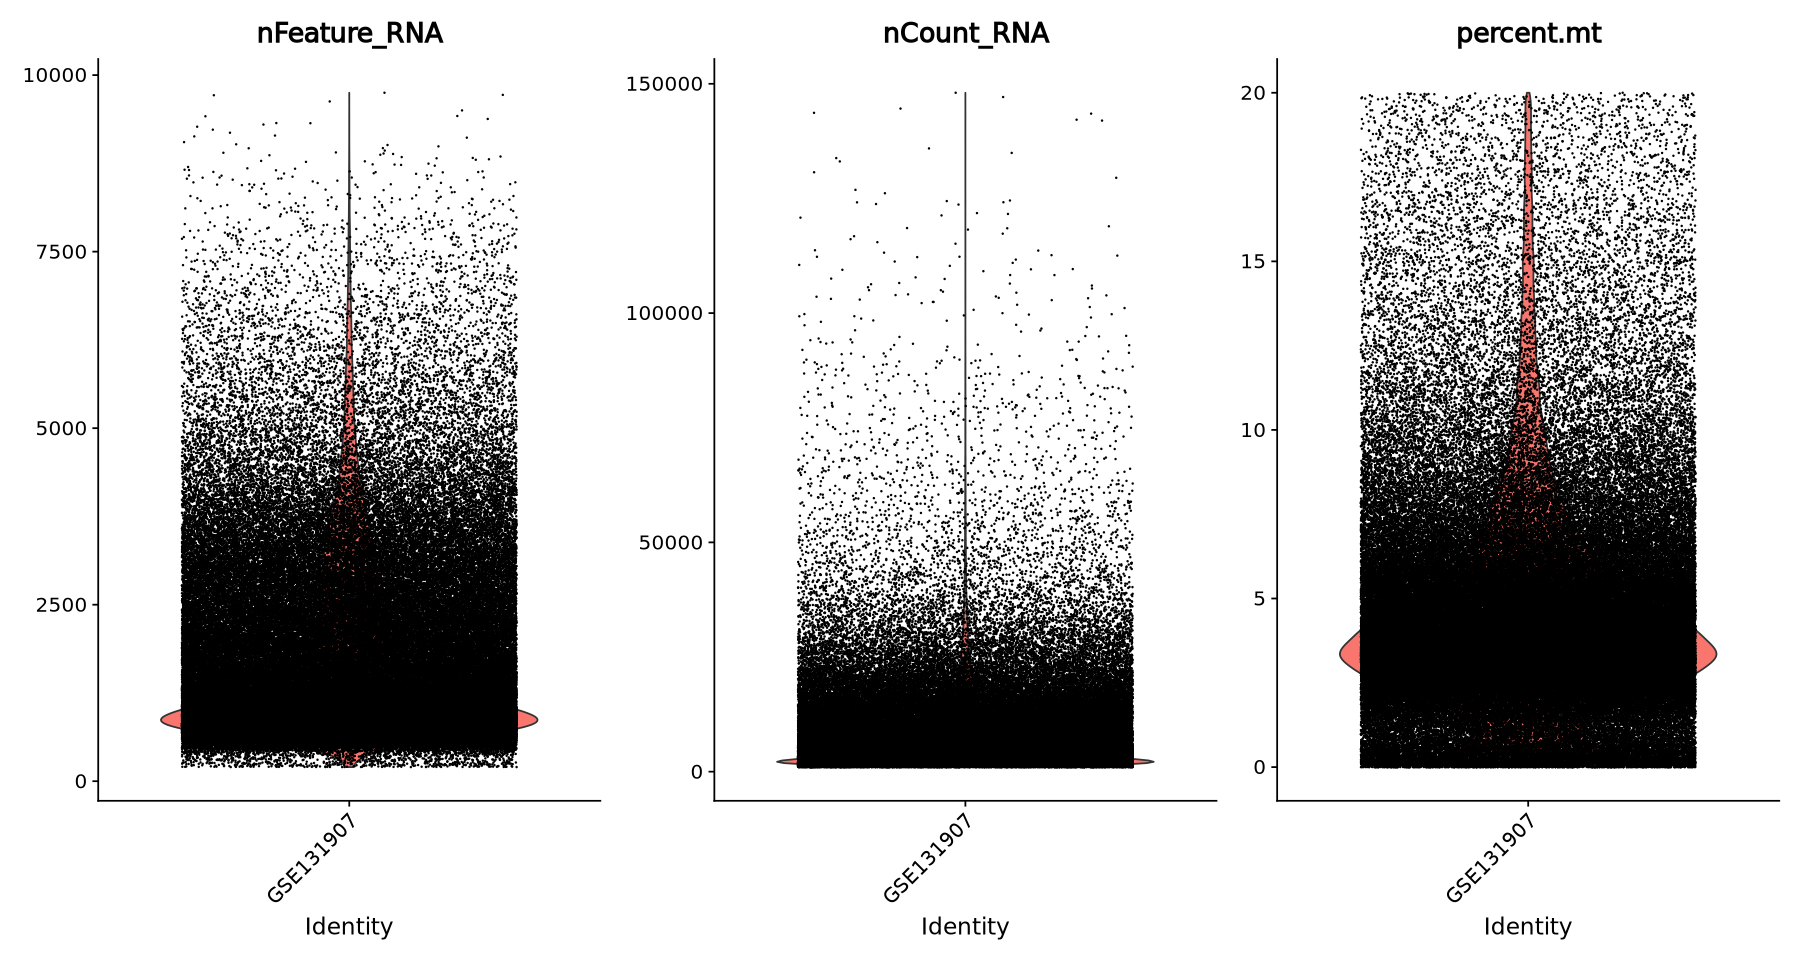

In [130]:
#QC Steps 
LUAD2[["percent.mt"]] <- PercentageFeatureSet(LUAD2, pattern = "^MT-")
#Visualise QC metrics
options(repr.plot.height=8, repr.plot.width=15)
VlnPlot(LUAD2, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [131]:
#Normalise the data
LUAD2 <- NormalizeData(LUAD2)
#Find variable features
LUAD2 <- FindVariableFeatures(LUAD2, selection.method = "vst", nfeatures = 2000)
#Scale the data
LUAD2 <- ScaleData(LUAD2, vars.to.regress = c("percent.mt", "nCount_RNA"))
#Run PCA
LUAD2 <- RunPCA(LUAD2, features = VariableFeatures(object = LUAD2))

Normalizing layer: counts.1

Normalizing layer: counts.2

Normalizing layer: counts.3

Normalizing layer: counts.4

Normalizing layer: counts.5

Normalizing layer: counts.6

Normalizing layer: counts.7

Normalizing layer: counts.8

Normalizing layer: counts.9

Normalizing layer: counts.10

Normalizing layer: counts.11

Normalizing layer: counts.12

Normalizing layer: counts.13

Normalizing layer: counts.14

Normalizing layer: counts.15

Normalizing layer: counts.16

Normalizing layer: counts.17

Normalizing layer: counts.18

Normalizing layer: counts.19

Normalizing layer: counts.20

Normalizing layer: counts.21

Normalizing layer: counts.22

Normalizing layer: counts.23

Normalizing layer: counts.24

Normalizing layer: counts.25

Normalizing layer: counts.26

Normalizing layer: counts.27

Normalizing layer: counts.28

Normalizing layer: counts.29

Normalizing layer: counts.30

Normalizing layer: counts.31

Normalizing layer: counts.32

Normalizing layer: counts.33

Normalizing layer: 

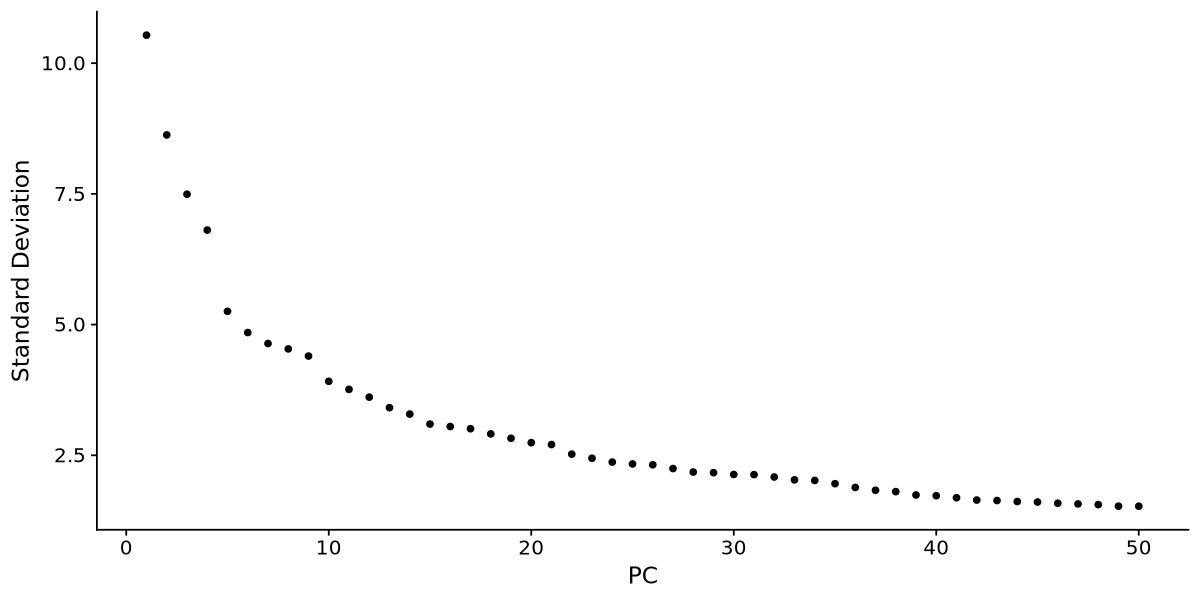

In [132]:
#make elbow plot
options(repr.plot.height=5, repr.plot.width=10)
ElbowPlot(LUAD2, ndims=50)
#in GSE213243 decided to use 40 PC, staying consistent across datasets

In [133]:
#Find neighbours (make sure number matches no. features chosen above)
LUAD2 <- FindNeighbors(LUAD2, dims = 1:40)

Computing nearest neighbor graph

Computing SNN



In [134]:
#Run UMAP
LUAD2 <- RunUMAP(LUAD2, dims = 1:40)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:30:33 UMAP embedding parameters a = 0.9922 b = 1.112

14:30:33 Read 150756 rows and found 40 numeric columns

14:30:33 Using Annoy for neighbor search, n_neighbors = 30

14:30:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:30:48 Writing NN index file to temp file /scratch/temp/9772316/RtmpO98Cre/file23e24e7295f0b4

14:30:48 Searching Annoy index using 1 thread, search_k = 3000

14:31:38 Annoy recall = 100%

14:31:39 Commencing smooth kNN distance calibration using 1 thread
 with

In [135]:
#Cluster, resolution here set to 0.2
LUAD2 <- FindClusters(LUAD2, resolution = 0.2)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 150756
Number of edges: 5385230

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9753
Number of communities: 26
Elapsed time: 56 seconds


1 singletons identified. 25 final clusters.



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



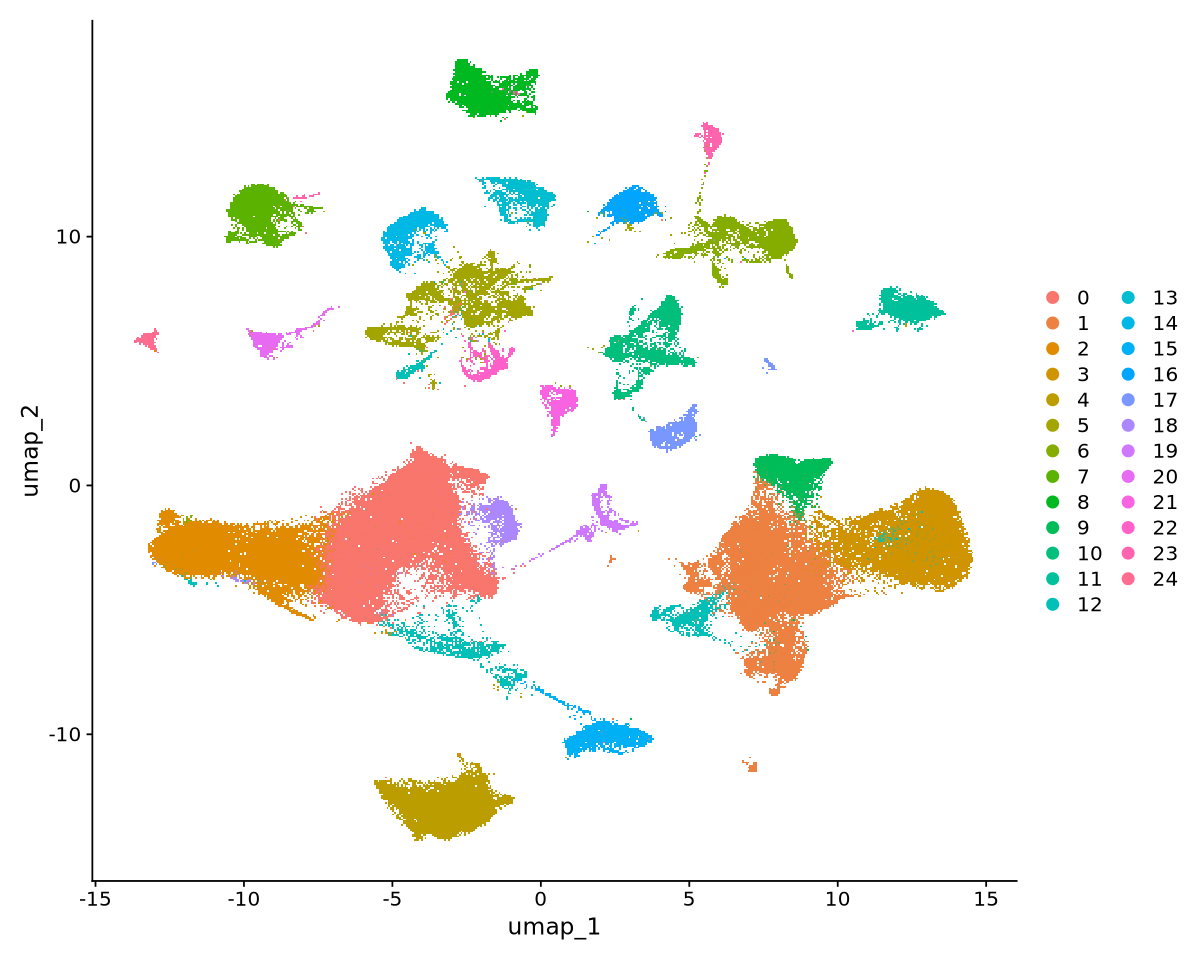

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



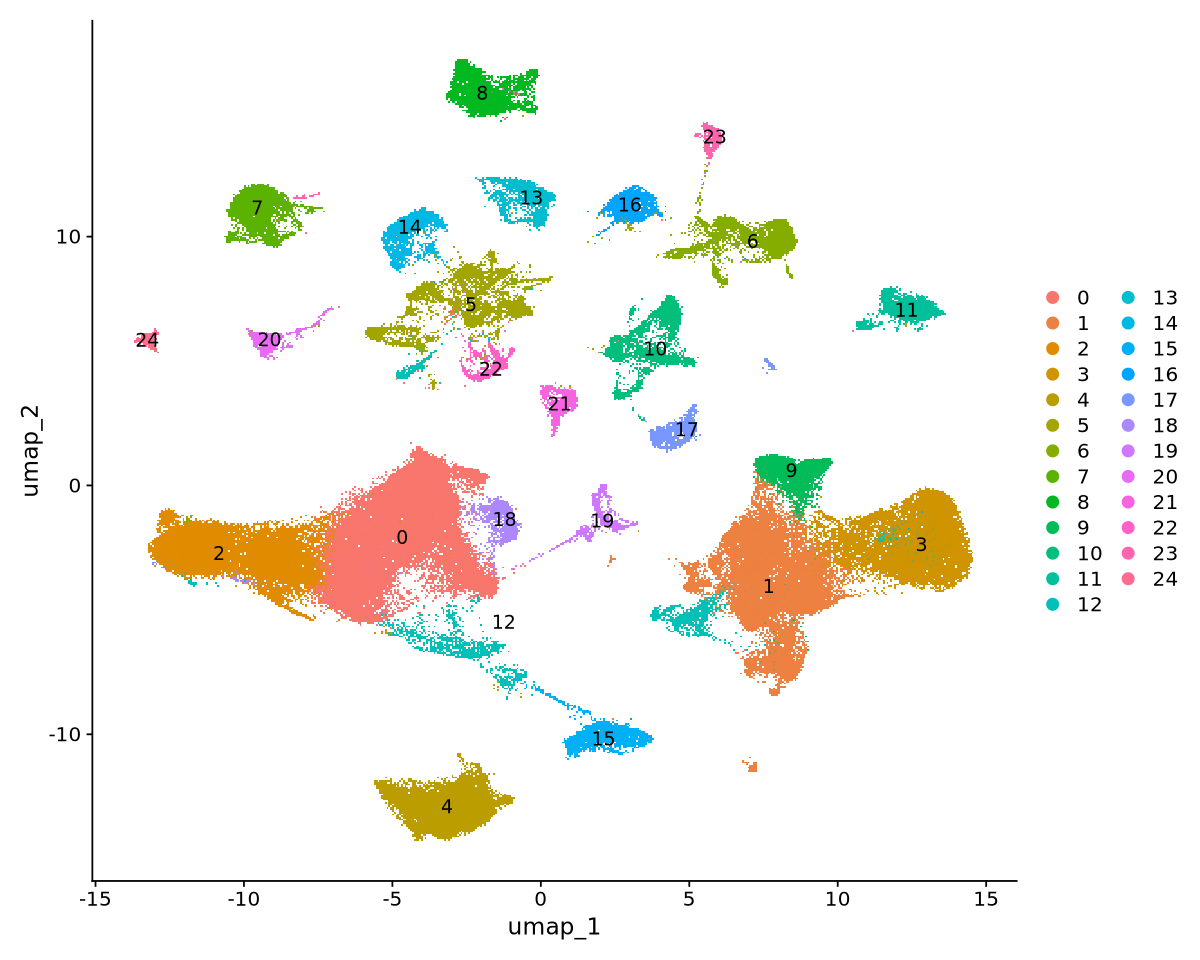

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



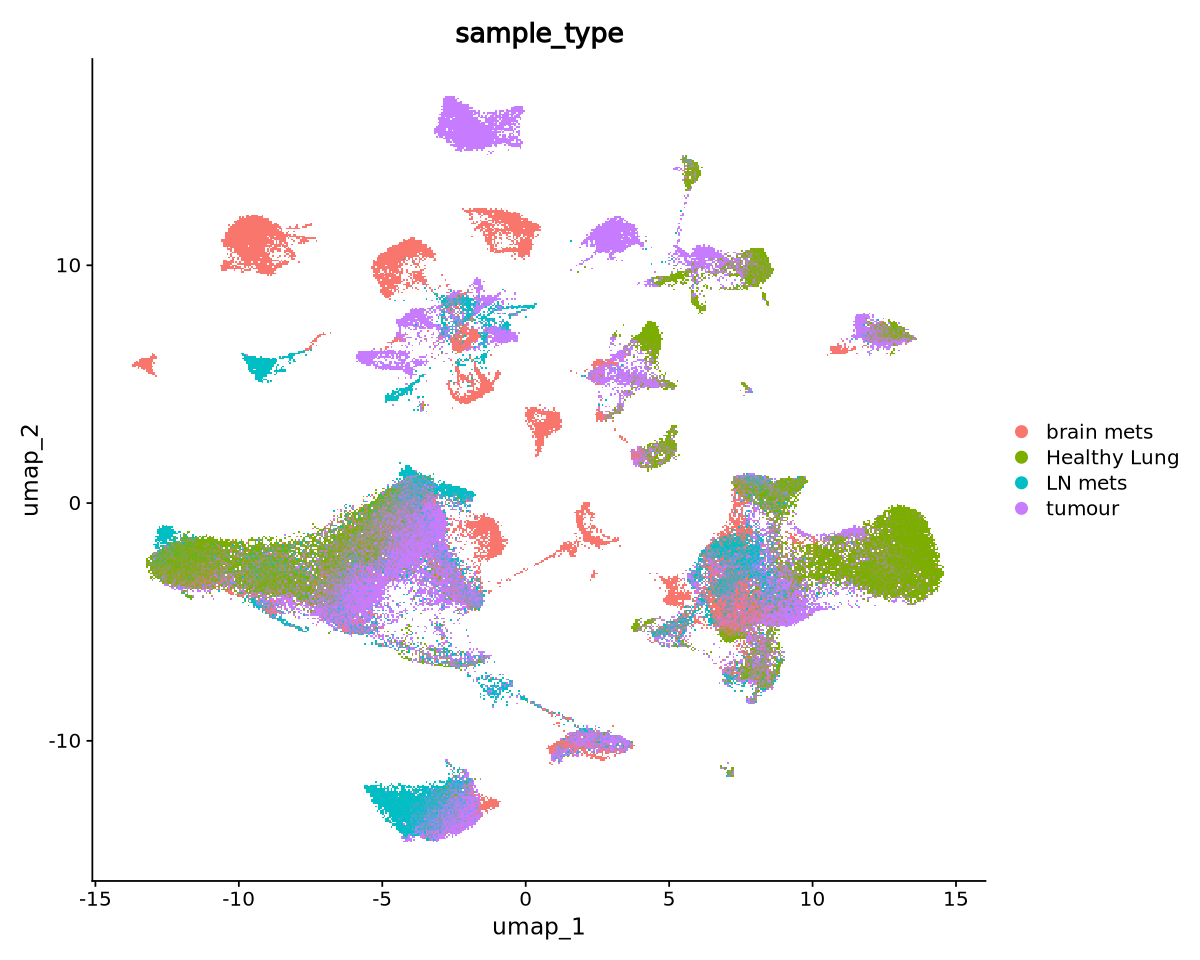

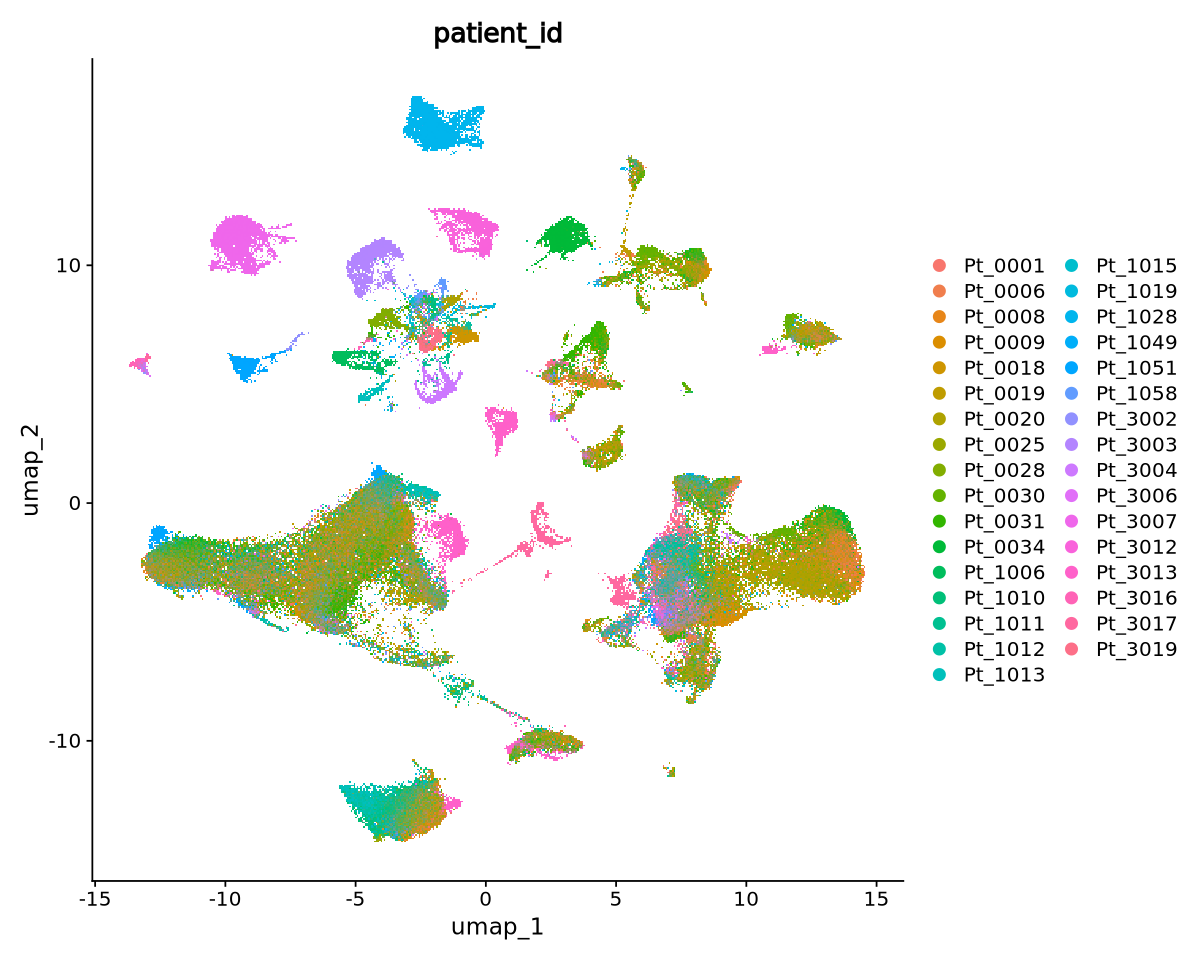

In [136]:
#Plot UMAP
options(repr.plot.height=8, repr.plot.width=10)
DimPlot(LUAD2, reduction = "umap")
DimPlot(LUAD2, reduction = "umap", label=TRUE)
DimPlot(LUAD2, reduction = "umap", group = "sample_type")
DimPlot(LUAD2, reduction = "umap", group = "patient_id")

In [137]:
#Save the object at this point so it can be loaded in without running steps above
saveRDS(LUAD2, file = "/scratch/user/s4436039/scdata/GSE131907/GSE131907.RDS")

#### Next part of code is about determining which cluster is the myeloid cells

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

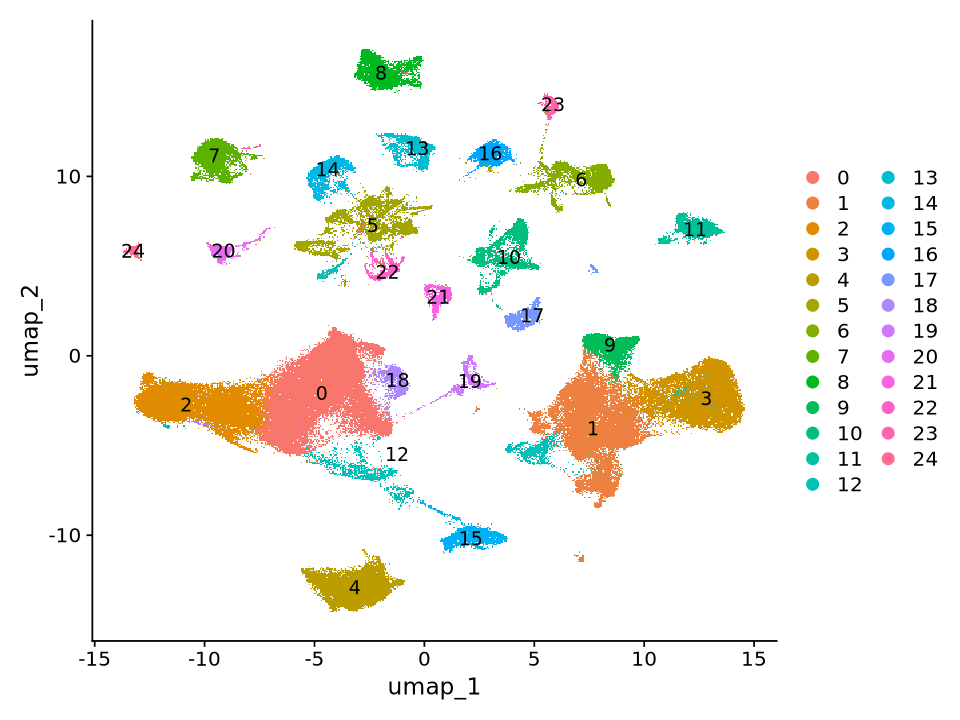

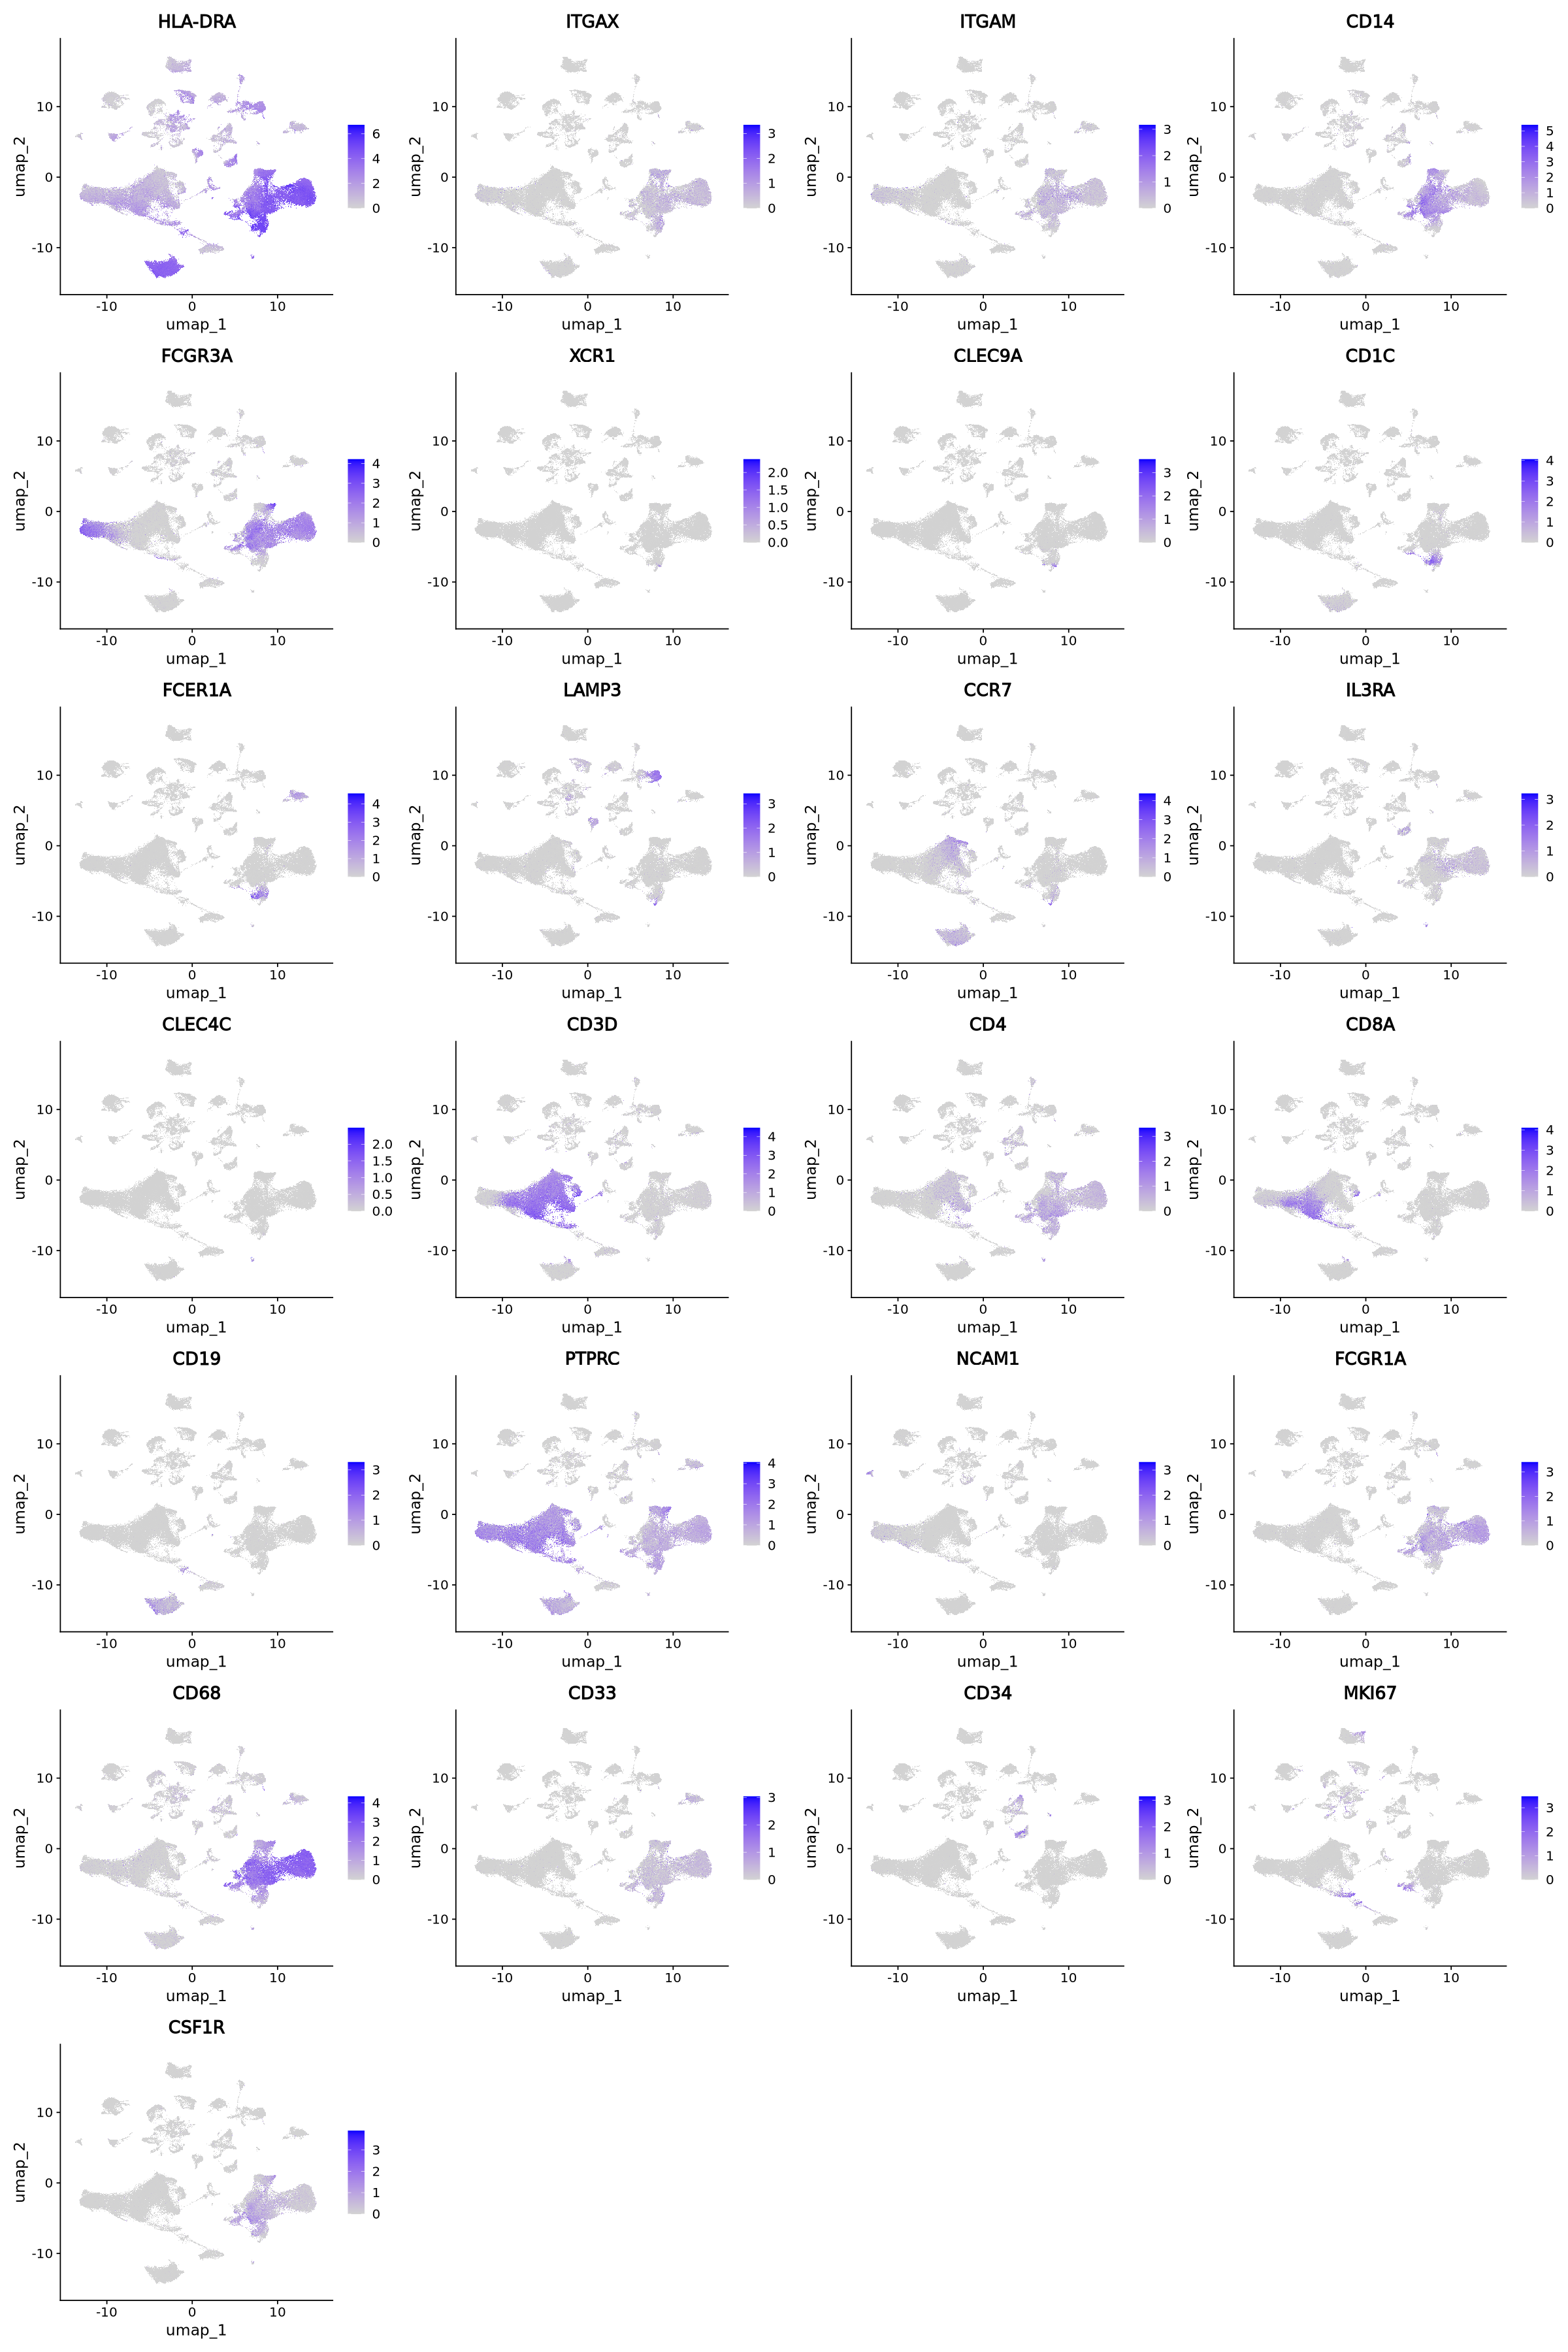

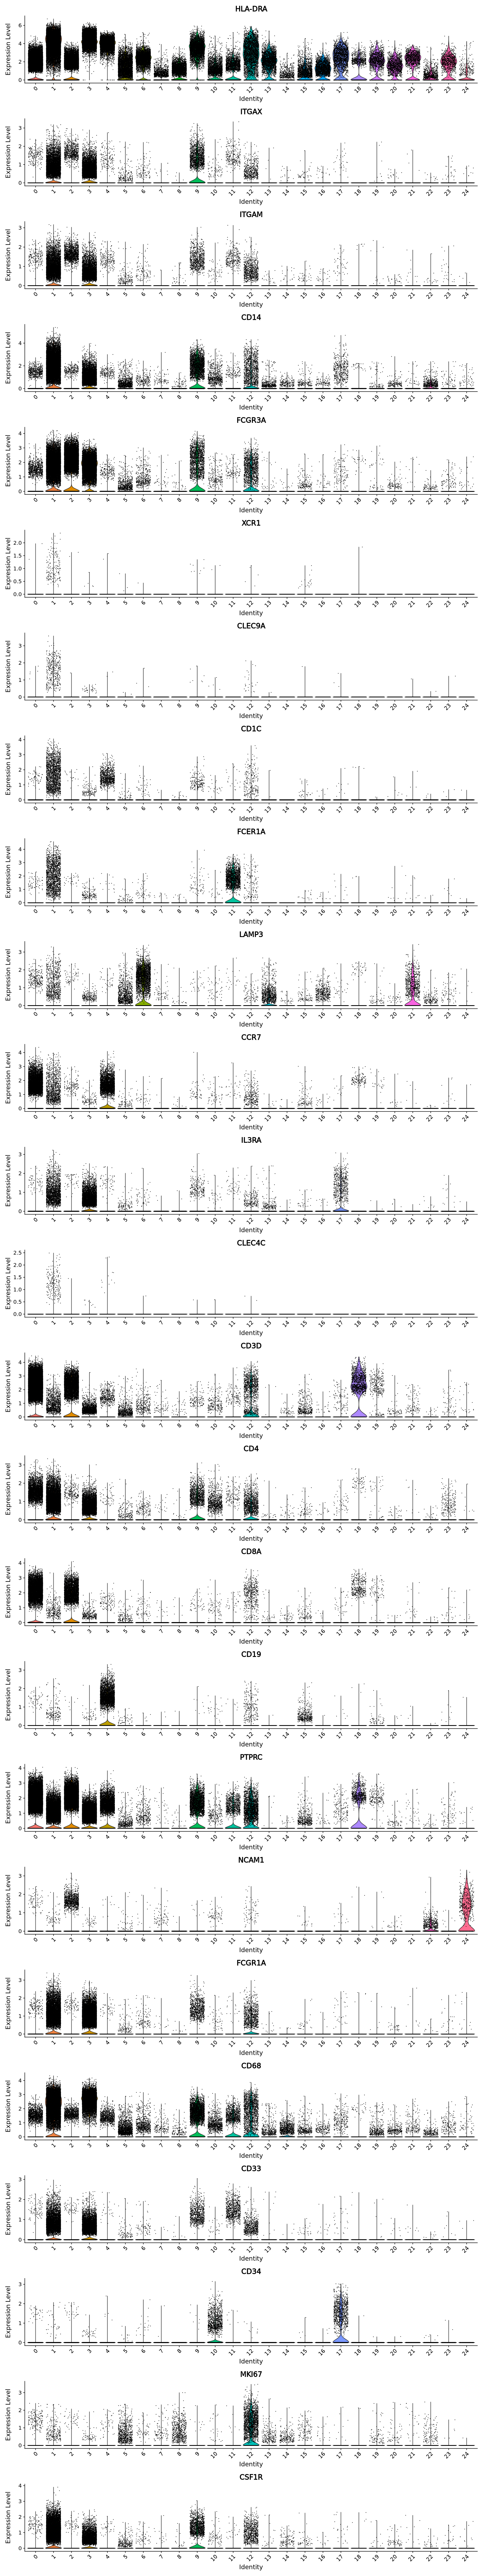

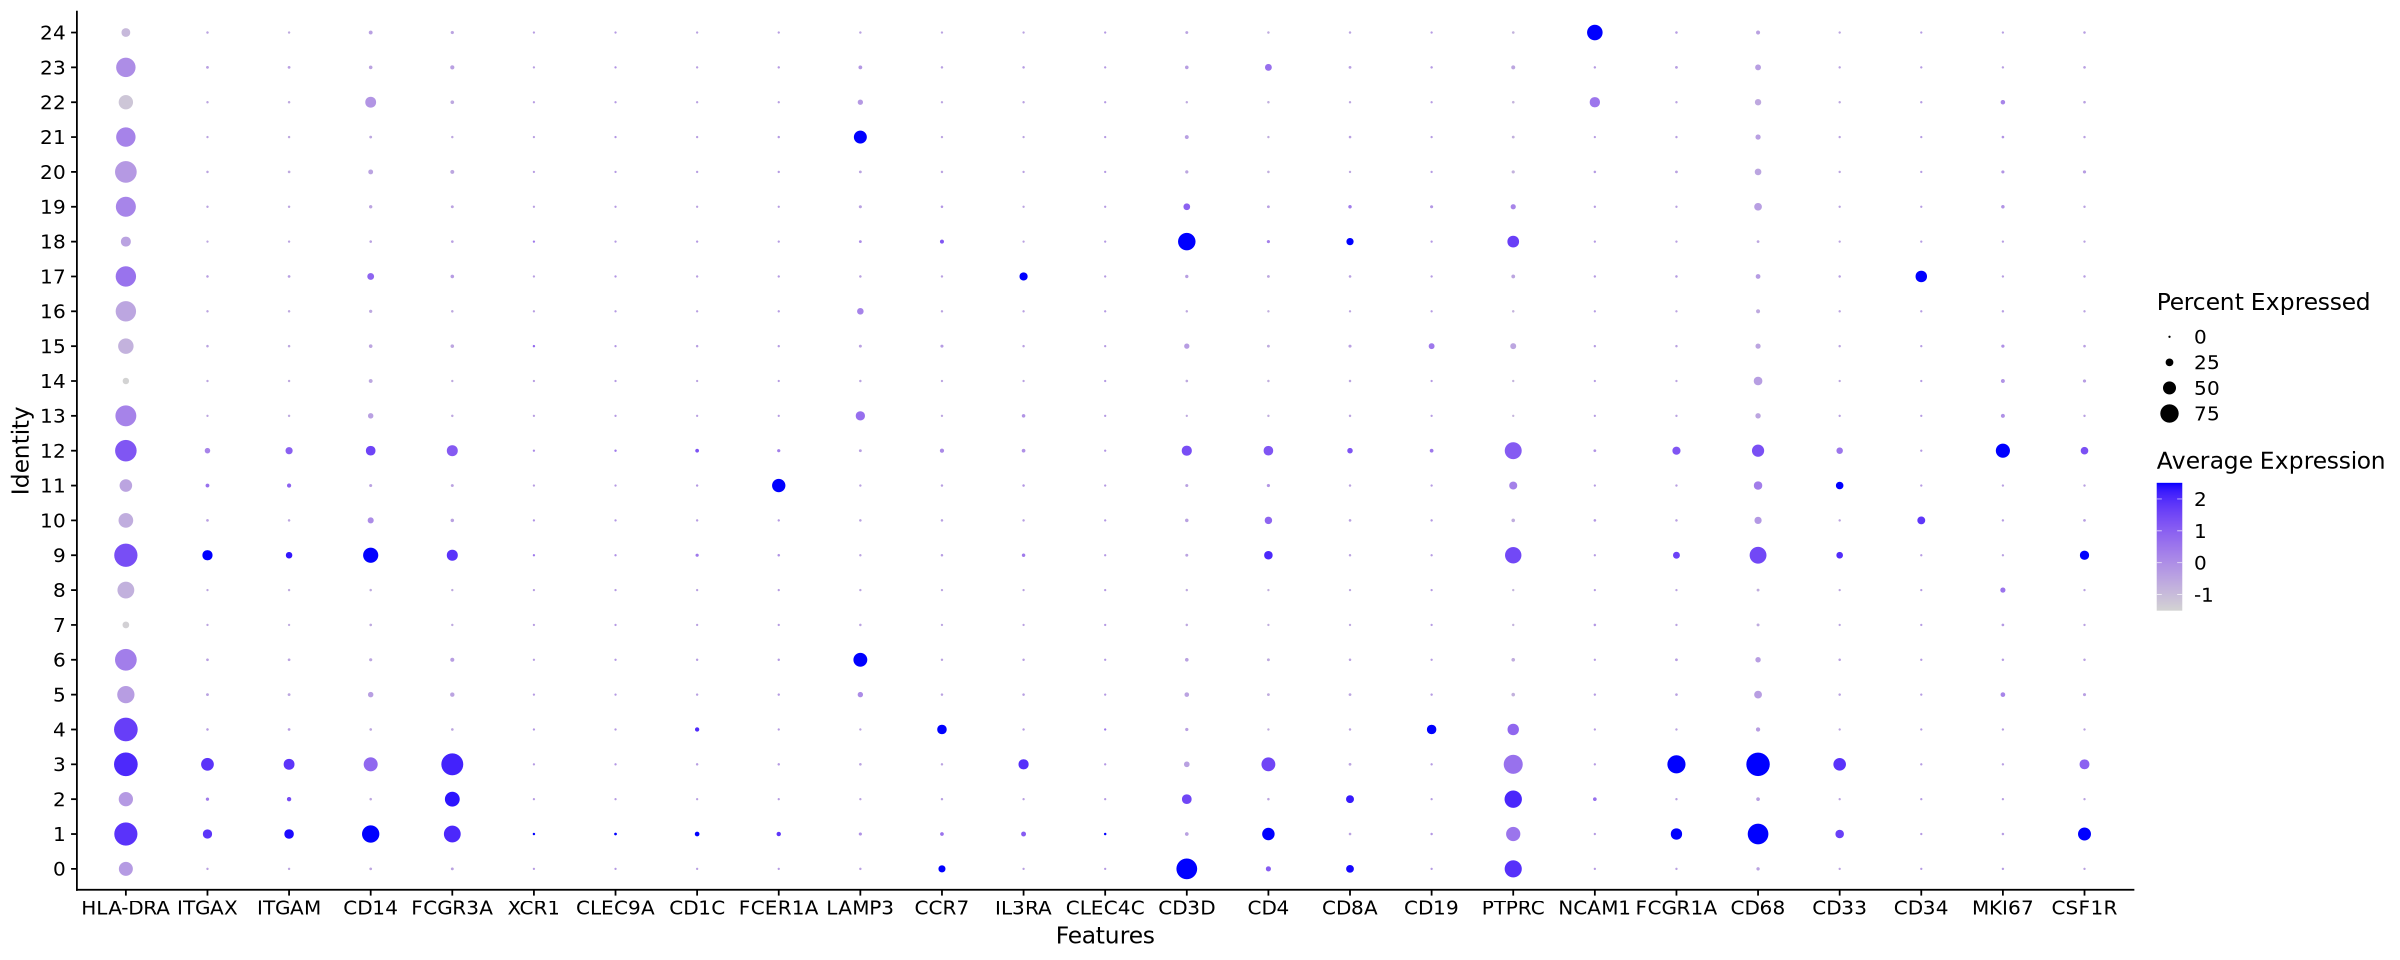

In [138]:
#Same genes over UMAP
options(repr.plot.height=6, repr.plot.width=8)
DimPlot(LUAD2, reduction = "umap", label=TRUE)

options(repr.plot.height=30, repr.plot.width=20)
FeaturePlot(LUAD2, features = c("HLA-DRA", "ITGAX", "ITGAM", "CD14", "FCGR3A", "XCR1", "CLEC9A", "CD1C", "FCER1A", "LAMP3", "CCR7", "IL3RA", "CLEC4C", "CD3D", "CD4", "CD8A", "CD19", "PTPRC", "NCAM1", "FCGR1A", "CD68", "CD33", "CD34", "MKI67", "CSF1R"), order = TRUE)

#Violin plots of classic markers
options(repr.plot.height=80, repr.plot.width=15)
VlnPlot(LUAD2, features = c("HLA-DRA", "ITGAX", "ITGAM", "CD14", "FCGR3A", "XCR1", "CLEC9A", "CD1C", "FCER1A", "LAMP3", "CCR7", "IL3RA", "CLEC4C", "CD3D", "CD4", "CD8A", "CD19", "PTPRC", "NCAM1", "FCGR1A", "CD68", "CD33", "CD34", "MKI67", "CSF1R"), ncol=1)

#Same as above but dot plot
options(repr.plot.height=8, repr.plot.width=20)
DotPlot(LUAD2, features = c("HLA-DRA", "ITGAX", "ITGAM", "CD14", "FCGR3A", "XCR1", "CLEC9A", "CD1C", "FCER1A", "LAMP3", "CCR7", "IL3RA", "CLEC4C", "CD3D", "CD4", "CD8A", "CD19", "PTPRC", "NCAM1", "FCGR1A", "CD68", "CD33", "CD34", "MKI67", "CSF1R"))

#### From above it looks like clusters 1,3,9 are the myeloid cells, now subsetting out these clusters

In [139]:
head(LUAD2@meta.data)

orig.ident nCount_RNA
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06 GSE131907  2859      
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 GSE131907  3323      
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 GSE131907  3958      
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06 GSE131907  1695      
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 GSE131907  3301      
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 GSE131907  3805      
                                                  nFeature_RNA sample_meta
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06  864         LUNG_T06   
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 1113         LUNG_T06   
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 1019         LUNG_T06   
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06  711         LUNG_T06   
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 1060         LUNG_T06   
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 1277         LUNG_T06   
                                                  sample_type cancer_type
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06 tumour      LUAD       
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 tumour      LUAD       
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 tumour      LUAD       
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06 tumour      LUAD       
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 tumour      LUAD       
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 tumour      LUAD       
                                                  patient_id
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06 Pt_0006   
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 Pt_0006   
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 Pt_0006   
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06 Pt_0006   
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 Pt_0006   
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 Pt_0006   
                                                  sample_id           
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06 GSE131907_LUAD_T0006
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 GSE131907_LUAD_T0006
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 GSE131907_LUAD_T0006
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06 GSE131907_LUAD_T0006
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 GSE131907_LUAD_T0006
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 GSE131907_LUAD_T0006
                                                  percent.mt RNA_snn_res.0.2
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06 2.868136   0              
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 3.912128   0              
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 3.309752   4              
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06 9.498525   1              
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 2.453802   0              
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 4.047306   0              
                                                  seurat_clusters
GSE131907_LUAD_Tu_T0006_AAACCTGAGCGACGTA_LUNG_T06 0              
GSE131907_LUAD_Tu_T0006_AAACCTGAGGCAAAGA_LUNG_T06 0              
GSE131907_LUAD_Tu_T0006_AAACCTGAGTGTTGAA_LUNG_T06 4              
GSE131907_LUAD_Tu_T0006_AAACCTGAGTTGCAGG_LUNG_T06 1              
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCACAC_LUNG_T06 0              
GSE131907_LUAD_Tu_T0006_AAACCTGCAATCAGAA_LUNG_T06 0

In [140]:
myeloid_LUAD2 <- subset(LUAD2, subset = RNA_snn_res.0.2 %in% c("1","3","9"))

In [141]:
LUAD2
myeloid_LUAD2

An object of class Seurat 
29634 features across 150756 samples within 1 assay 
Active assay: RNA (29634 features, 2000 variable features)
 87 layers present: counts.1, counts.2, counts.3, counts.4, counts.5, counts.6, counts.7, counts.8, counts.9, counts.10, counts.11, counts.12, counts.13, counts.14, counts.15, counts.16, counts.17, counts.18, counts.19, counts.20, counts.21, counts.22, counts.23, counts.24, counts.25, counts.26, counts.27, counts.28, counts.29, counts.30, counts.31, counts.32, counts.33, counts.34, counts.35, counts.36, counts.37, counts.38, counts.39, counts.40, counts.41, counts.42, counts.43, data.1, data.2, data.3, data.4, data.5, data.6, data.7, data.8, data.9, data.10, data.11, data.12, data.13, data.14, data.15, data.16, data.17, data.18, data.19, data.20, data.21, data.22, data.23, data.24, data.25, data.26, data.27, data.28, data.29, data.30, data.31, data.32, data.33, data.34, data.35, data.36, data.37, data.38, data.39, data.40, data.41, data.42, data.43,

An object of class Seurat 
29634 features across 36524 samples within 1 assay 
Active assay: RNA (29634 features, 2000 variable features)
 87 layers present: counts.1, counts.2, counts.3, counts.4, counts.5, counts.6, counts.7, counts.8, counts.9, counts.10, counts.11, counts.12, counts.13, counts.14, counts.15, counts.16, counts.17, counts.18, counts.19, counts.20, counts.21, counts.22, counts.23, counts.24, counts.25, counts.26, counts.27, counts.28, counts.29, counts.30, counts.31, counts.32, counts.33, counts.34, counts.35, counts.36, counts.37, counts.38, counts.39, counts.40, counts.41, counts.42, counts.43, data.1, data.2, data.3, data.4, data.5, data.6, data.7, data.8, data.9, data.10, data.11, data.12, data.13, data.14, data.15, data.16, data.17, data.18, data.19, data.20, data.21, data.22, data.23, data.24, data.25, data.26, data.27, data.28, data.29, data.30, data.31, data.32, data.33, data.34, data.35, data.36, data.37, data.38, data.39, data.40, data.41, data.42, data.43, 

In [142]:
saveRDS(myeloid_LUAD2, "/scratch/user/s4436039/scdata/GSE131907/GSE131907_myeloid.RDS")

#### Following the above then need to move entire GSE131907 folder from scratch to rdm
``` bash
rsync -azvhp /scratch/user/s4436039/scdata/GSE131907/ /QRISdata/Q5935/nikita/scdata/GSE131907
```